# Deep Learning for Satellite Image Classification

## Chapter 2


I have to say I didn't get the milestone requirements.  I ended up peeking at the reference solution. What it was doing was clear, but the code wasn't.  I went over the code and re-wrote it so it's clearer (at least to me).

The reference solution doesn't have any code to do train/test split either.  I'm guessing traing set is a series of pairs of image files.  X is the s2cloudless file, corresponding mask is the y output. 

In [1]:
from PIL import Image, ImageDraw
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import json, os, glob
import rasterio

VGG JSON looks like below:

```json
{'aral_sea_s2cloudless-2016.jpg': 
  {'fileref': '',
   'size': 3297855,
   'filename': 'aral_sea_s2cloudless-2016.jpg',
   'base64_img_data': '',
   'file_attributes': {},
   'regions': 
     {'0': 
       {'shape_attributes': 
         {'name': 'polygon',
          'all_points_x': [495.7967197967195, ..],
          'all_points_y': [2420.320628320627, ..],
          'region_attributes': 
            {'label': 'water'}
         },
       ...
     }
  }
},
...
```

In [2]:
# Retrieve X and Y points of all polygon in the file entry from a VGG JSON
def get_polygon_points(file_info):
    X = [] 
    Y = [] 
    for region, shape in file_info['regions'].items(): 
        all_points_x = shape['shape_attributes']['all_points_x']
        all_points_y = shape['shape_attributes']['all_points_y']
        X.append(all_points_x)
        Y.append(all_points_y)
    return Y,X #image coordinates are flipped relative to json coordinates

In [3]:
mask_path = '/home/aki/ManningLiveProjects/2_Data/masks/'
def write_mask(name, image, polygons):
    X, Y = polygons
    
    
    # get the dimensions of the image
    nx, ny, nz = np.shape(image)
    mask = np.zeros((ny,nx))
    
    for x,y in zip(X,Y):
        # the ImageDraw.Draw().polygon function we will use to create the mask
        # requires the x's and y's are interweaved, which is what the following
        # one-liner does    
        polygon = np.vstack((x,y)).reshape((-1,),order='F').tolist()
        
        # create a mask image of the right size and infill according to the polygon
        x,y = y,x 
        img = Image.new('L', (ny, nx), 0)
        ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
        # turn into a numpy array
        m = np.flipud(np.rot90(np.array(img)))
        try:
            mask = mask + m
        except:
            mask = mask + m.T
        
    mask_name = mask_path + name + "_mask.jpg"
    matplotlib.image.imsave(mask_name, mask.astype('uint8'))    
    
    return(mask_name)

In [4]:
vgg_path = '/home/aki/ManningLiveProjects/2_Data/s2cloudless_labels/all_labels.json'

vgg_data = json.load(open(vgg_path))
image_files = list(vgg_data.keys())
all_polygons = []
for vgg_item_name, vgg_item in vgg_data.items():
    all_polygons.append(get_polygon_points(vgg_item))

In [5]:
images_path = '/home/aki/ManningLiveProjects/2_Data/s2cloudless_imagery/data/'
all_images = []
for image_name in image_files:
    image_name = images_path + image_name
    with rasterio.open(image_name) as img:
        all_images.append(img.read().T)

/home/aki/miniconda3/envs/liveproject/lib/python3.7/site-packages/rasterio/__init__.py:193: UserWarning: Dataset has no geotransform set.  Default transform will be applied (Affine.identity())
  s.start()


In [6]:
all_masks = []
for i in range(len(image_files)):
    polygons = all_polygons[i]
    image = all_images[i]
    name = image_files[i]
    all_masks.append(write_mask(name, image, polygons))

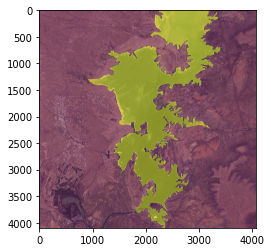

In [7]:
plt.imshow(mpimg.imread(images_path + image_files[10]))
plt.imshow(mpimg.imread(all_masks[10]), cmap='gray', alpha=0.5)

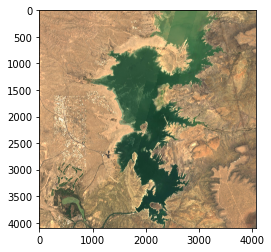

In [8]:
plt.imshow(mpimg.imread(images_path + image_files[10]))

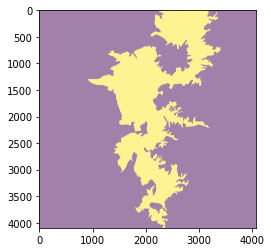

In [9]:
plt.imshow(mpimg.imread(all_masks[10]), cmap='gray', alpha=0.5)